In [1]:
# ! pip install mediapipe opencv-python pillow

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730293300.887038    9481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


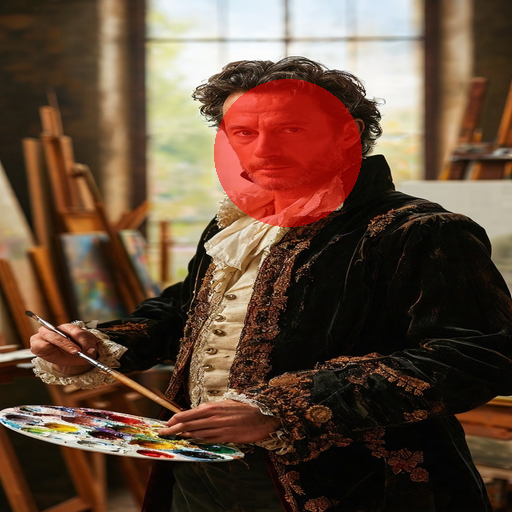

In [3]:
import mediapipe as mp
import numpy as np
from PIL import Image, ImageDraw
import cv2

def create_face_mask(image_path, padding=20):
    """
    이미지에서 얼굴을 감지하고 마스크를 생성합니다.
    
    Args:
        image_path: 입력 이미지 경로
        padding: 얼굴 주변에 추가할 여백 픽셀
    
    Returns:
        원본 이미지와 마스크 이미지 (PIL Image)
    """
    # MediaPipe 얼굴 감지 모델 초기화
    mp_face_detection = mp.solutions.face_detection
    
    # 이미지 로드 및 리사이즈
    image = Image.open(image_path)
    image = image.resize((512, 512), Image.Resampling.LANCZOS)
    
    # PIL Image를 CV2 형식으로 변환
    cv_image = np.array(image)
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2BGR)
    
    # 얼굴 감지
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
        
    # 마스크 이미지 생성
    mask = Image.new('L', (512, 512), 0)  # 검은색 마스크
    draw = ImageDraw.Draw(mask)
    
    if results.detections:
        for detection in results.detections:
            # 바운딩 박스 좌표 얻기
            bbox = detection.location_data.relative_bounding_box
            h, w, _ = cv_image.shape
            
            # 픽셀 좌표로 변환
            x = int(bbox.xmin * w)
            y = int(bbox.ymin * h)
            width = int(bbox.width * w)
            height = int(bbox.height * h)
            
            # 패딩 추가 및 이미지 경계 확인
            x = max(0, x - padding)
            y = max(0, y - padding)
            width = min(512 - x, width + 2 * padding)
            height = min(512 - y, height + 2 * padding)
            
            # 마스크에 흰색 타원 그리기 (얼굴 형태에 더 자연스러움)
            draw.ellipse([x, y, x + width, y + height], fill=255)
    
    return image, mask

def preview_mask(image, mask):
    """마스크 프리뷰를 생성합니다."""
    # 마스크 영역을 시각화하기 위해 반투명한 빨간색으로 표시
    preview = image.copy()
    overlay = Image.new('RGBA', image.size, (255, 0, 0, 0))
    mask_rgba = mask.convert('RGBA')
    overlay.paste((255, 0, 0, 128), mask=mask)
    preview = Image.alpha_composite(preview.convert('RGBA'), overlay)
    return preview

# 사용 예시
# image_path = "input_image/gonsoo_fall.jpg"  # 얼굴 이미지 경로
image_path = "input_image/painter.jpeg"  # 얼굴 이미지 경로
image, mask = create_face_mask(image_path, padding=30)

# 결과 확인
preview = preview_mask(image, mask)
display(preview)  # 주피터 노트북에서 결과 표시

# 마스크 저장
mask.save("face_mask.png")